In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, abspath
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

In [3]:
import sys
sys.path.insert(0, abspath("./../../"))

In [4]:
from utils.pandas import apply_filters
from utils_local import colors_v1, read_spreadsheet

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Create dataframe

In [6]:
# df = pd.DataFrame(
#     {
#         "group": ["Kinetics-400", "UCF-101", "NTU-60", "Gym-99", "SS-v2", "EPIC-Kitchens-100", "Charades", "AVA"],
#         "Label overlap (\%)": [100.0, 80.0, 30.0, 0.0, 0.0, 0.0, 10.0, 35.0],
#         "PoV": ["Third", "Third", "Third", "Third", "First", "First", "Third", "Third"],
#         "Environment": ["Varied", "Varied", "Lab", "Stadium", "Household", "Kitchen", "Household", "Films"],
#         "Action \\\ length (sec)": [10.0, 7.21, 2.82, 1.75, 3.80, 3.19, 12.8, 2.70],
#         "Temporal \\\ awareness (sec)": [10, 7, 9, 9, 22, 32, 32, 12],
#     }
# )

In [7]:
df = pd.DataFrame(
    {
        "group": ["Kinetics-400", "UCF-101", "NTU-60", "Gym-99", "SS-v2", "EPIC-Kitchens-100", "Charades", "AVA"],
        "Label overlap": [100.0, 80.0, 30.0, 0.0, 0.0, 0.0, 10.0, 35.0],
        "PoV": ["Third", "Third", "Third", "Third", "First", "First", "Third", "Third"],
        "Environment": ["Varied", "Varied", "Lab", "Stadium", "Household", "Kitchen", "Household", "Films"],
        "Action \\\ length": [10.0, 7.21, 2.82, 1.75, 3.80, 3.19, 12.8, 2.70],
        "Temporal \\\ awareness": [10, 7, 9, 9, 22, 32, 32, 12],
    }
)

In [8]:
df

,group,Label overlap,PoV,Environment,Action \\ length,Temporal \\ awareness
0,Kinetics-400,100.0,Third,Varied,10.00,10
1,UCF-101,80.0,Third,Varied,7.21,7
2,NTU-60,30.0,Third,Lab,2.82,9
3,Gym-99,0.0,Third,Stadium,1.75,9
4,SS-v2,0.0,First,Household,3.80,22
5,EPIC-Kitchens-100,0.0,First,Kitchen,3.19,32
6,Charades,10.0,Third,Household,12.80,32
7,AVA,35.0,Third,Films,2.70,12


In [9]:
# convert environment to scalar quantities

# ## discussed with Fida
# env_to_int = {
#     "Varied": 0.1,
#     "Films": 0.2,
#     "Stadium": 0.3,
#     "Lab": 0.4,
#     "Household": 0.5,
#     "Kitchen": 0.6,
# }

## discussed with Hazel
env_to_int = {
    "Varied": 0.1,
    "Films": 0.2,
    "Household": 0.4,
    "Stadium": 0.5,
    "Kitchen": 0.5,
    "Lab": 0.6,
}

df["Environment"].replace(env_to_int, inplace=True)

In [10]:
df

,group,Label overlap,PoV,Environment,Action \\ length,Temporal \\ awareness
0,Kinetics-400,100.0,Third,0.1,10.00,10
1,UCF-101,80.0,Third,0.1,7.21,7
2,NTU-60,30.0,Third,0.6,2.82,9
3,Gym-99,0.0,Third,0.5,1.75,9
4,SS-v2,0.0,First,0.4,3.80,22
5,EPIC-Kitchens-100,0.0,First,0.5,3.19,32
6,Charades,10.0,Third,0.4,12.80,32
7,AVA,35.0,Third,0.2,2.70,12


In [11]:
# convert PoV to scalar quantities

pov_to_int = {
    "Third": 0.1,
    "First": 0.7,
}

df["PoV"].replace(pov_to_int, inplace=True)

In [12]:
df

,group,Label overlap,PoV,Environment,Action \\ length,Temporal \\ awareness
0,Kinetics-400,100.0,0.1,0.1,10.00,10
1,UCF-101,80.0,0.1,0.1,7.21,7
2,NTU-60,30.0,0.1,0.6,2.82,9
3,Gym-99,0.0,0.1,0.5,1.75,9
4,SS-v2,0.0,0.7,0.4,3.80,22
5,EPIC-Kitchens-100,0.0,0.7,0.5,3.19,32
6,Charades,10.0,0.1,0.4,12.80,32
7,AVA,35.0,0.1,0.2,2.70,12


In [13]:
df.set_index("group", inplace=True)

In [14]:
df

,Label overlap,PoV,Environment,Action \\ length,Temporal \\ awareness
group,,,,,
Kinetics-400,100.0,0.1,0.1,10.00,10
UCF-101,80.0,0.1,0.1,7.21,7
NTU-60,30.0,0.1,0.6,2.82,9
Gym-99,0.0,0.1,0.5,1.75,9
SS-v2,0.0,0.7,0.4,3.80,22
EPIC-Kitchens-100,0.0,0.7,0.5,3.19,32
Charades,10.0,0.1,0.4,12.80,32
AVA,35.0,0.1,0.2,2.70,12


In [15]:
# normalize df s.t. each column has values between min and max

from sklearn import preprocessing

min_val = 0.2
max_val = 1.0

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(min_val, max_val))
x_scaled = min_max_scaler.fit_transform(x)
# pd.DataFrame(x_scaled)

df_scaled = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

In [16]:
# invert label overlap (since we want 100% to be at origin)
invert_label_overlap = False
if invert_label_overlap:
    label_overlap_column = [x for x in list(df.columns) if x.startswith("Label")][0]
    df_scaled[label_overlap_column] = 1 - df_scaled[label_overlap_column]

In [17]:
df_scaled

,Label overlap,PoV,Environment,Action \\ length,Temporal \\ awareness
group,,,,,
Kinetics-400,1.00,0.2,0.20,0.797285,0.296
UCF-101,0.84,0.2,0.20,0.595294,0.200
NTU-60,0.44,0.2,1.00,0.277466,0.264
Gym-99,0.20,0.2,0.84,0.200000,0.264
SS-v2,0.20,1.0,0.68,0.348416,0.680
EPIC-Kitchens-100,0.20,1.0,0.84,0.304253,1.000
Charades,0.28,0.2,0.68,1.000000,1.000
AVA,0.48,0.2,0.36,0.268778,0.360


In [18]:
def embolden(string):
    return "\\textbf{%s}" % string

In [19]:
colormap = {
    "Kinetics-400": ("gray", "darkgray", 0.15),
    "UCF-101": ("yellow", "darkgoldenrod", 0.3),
    "NTU-60": ("lightgreen", "green", 0.3),
    "SS-v2": ("pink", "red", 0.3),
    "Gym-99": ("violet", "indigo", 0.1),
    "EPIC-Kitchens-100": ("lightcyan", "darkblue", 0.3),
    "Charades": ("peachpuff", "chocolate", 0.3),
    "AVA": ("greenyellow", "olive", 0.1),
}

### Plot all together

In [20]:
cat_to_id = {
    'Label overlap': "A",
    'PoV': "B",
    "Environment": "C",
    'Action \\\\ length': "D",
    'Temporal \\\\ awareness': "E",
}

use_cat_ids = False

In [21]:
from collections import OrderedDict

In [22]:
colormap_ordered = OrderedDict(colormap)


key_order = ('Kinetics-400', 'UCF-101', 'NTU-60', 'Gym-99', 'SS-v2', 'EPIC-Kitchens-100', 'Charades', 'AVA')
colormap_ordered_correct = OrderedDict()
for k in key_order:
    colormap_ordered_correct[k] = colormap_ordered[k]

In [23]:
colormap_ordered_correct

OrderedDict([('Kinetics-400', ('gray', 'darkgray', 0.15)),
             ('UCF-101', ('yellow', 'darkgoldenrod', 0.3)),
             ('NTU-60', ('lightgreen', 'green', 0.3)),
             ('Gym-99', ('violet', 'indigo', 0.1)),
             ('SS-v2', ('pink', 'red', 0.3)),
             ('EPIC-Kitchens-100', ('lightcyan', 'darkblue', 0.3)),
             ('Charades', ('peachpuff', 'chocolate', 0.3)),
             ('AVA', ('greenyellow', 'olive', 0.1))])

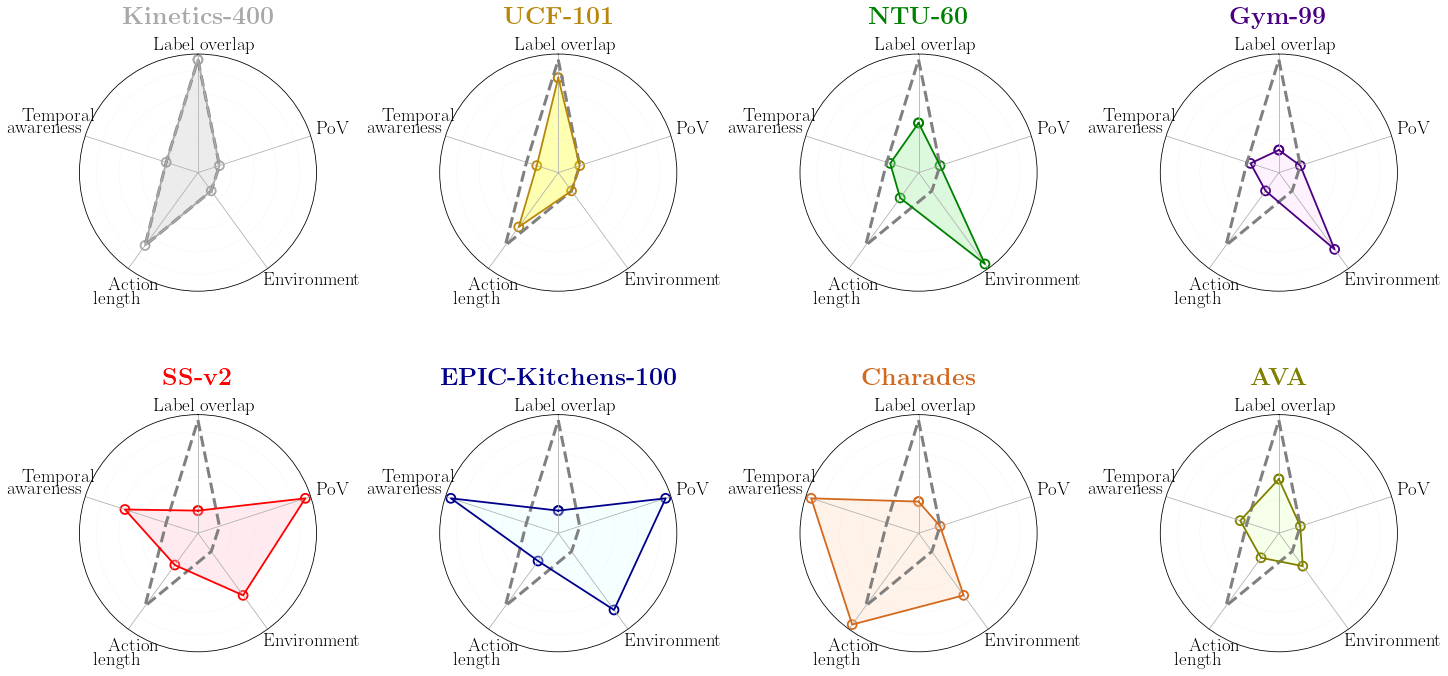

In [24]:
# define variables
# dataset = "UCF-101"
# dataset = "NTU-60"
# dataset = "SS-v2"
# dataset = "Gym-99"
# dataset = "EPIC-Kitchens-100"
# dataset = "Charades"
# dataset = "AVA"
# dataset = "Kinetics-400"

# fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={'projection': 'polar'})
# f = plt.figure(figsize=(22, 10))

if use_cat_ids:
    f = plt.figure(figsize=(20, 10 + 1), constrained_layout=True)
    gs = f.add_gridspec(3, 4, height_ratios=[45,45,10])
else:
    f = plt.figure(figsize=(20, 10), constrained_layout=True)
    gs = f.add_gridspec(2, 4, height_ratios=[50,50])

reference_dataset = "Kinetics-400"
reference_line_config = {
    "color": "gray",
    "linewidth": 3.,
}

# define constants
titlesize = 25
tickssize = 0.75 * titlesize


for j,dataset in enumerate(colormap_ordered_correct):
    # ax = f.add_subplot(int(f"24{j+1}"), polar=True)
    ax = f.add_subplot(gs[j // 4, j % 4], polar=True)

    # ------- PART 1: Create background

    # number of variable
    categories=list(df_scaled)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_ylim(0.,1.05)

    # Draw one axe per variable + add labels
    bold_categories = [embolden(x) for x in categories]
    cat_ids = [cat_to_id[x] for x in categories]
    # plt.xticks(angles[:-1], categories, fontsize=tickssize)
    if use_cat_ids:
        plt.xticks(angles[:-1], cat_ids, fontsize=tickssize)
    else:
        plt.xticks(angles[:-1], ["" for _ in categories], fontsize=tickssize)
        # pass
    

    # Draw ylabels
    plt.yticks([0.3,0.5,0.7,0.9], ["","","", ""], color="grey", size=7) 

    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values=df_scaled.loc[reference_dataset].values.flatten().tolist()
    values += values[:1]
    ax.plot(
        angles, values, linewidth=reference_line_config["linewidth"],
        linestyle='dashed', label="Kinetics", color=reference_line_config["color"])
    ax.fill(angles, values, reference_line_config["color"], alpha=0.0)

    # Ind2
    facecolor, linecolor, facealpha = colormap[dataset]
    values=df_scaled.loc[dataset].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1.8, linestyle='solid', label="UCF-101", color=linecolor)
    ax.scatter(angles, values, linewidth=1.8, linestyle='solid', label="UCF-101", color=linecolor, facecolor="none", s=80)
    ax.fill(angles, values, facecolor, alpha=facealpha)

    # Add legend
    # plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # make gridlines light
    gridlines = ax.yaxis.get_gridlines()
    for i in range(len(ax.get_yticks())):
        gridlines[i].set_color("lightgray")
        gridlines[i].set_linewidth(0.1)

    thetas = ax.get_xticks()
    if titlesize < 25:
        rdeltas = [0.08, 0.05, 0.08, 0.23, 0.53]
    elif titlesize == 35:
        rdeltas = [0.1, 0.05, 0.1, 0.3, 0.75]
    elif titlesize == 40:
        rdeltas = [0.1, 0.05, 0.1, 0.35, 0.6]
    
    if not use_cat_ids:
        to_show = categories
        rdeltas = [0.1, 0.05, 0.1, 0.35, 0.7]
        ax.text(-0.35, ax.get_ylim()[1] + rdeltas[0], s=to_show[0], fontsize=tickssize)
        ax.text(thetas[1], ax.get_ylim()[1] + rdeltas[1], s=to_show[1], fontsize=tickssize)
        ax.text(thetas[2] + 0.1, ax.get_ylim()[1] + rdeltas[2], s=to_show[2], fontsize=tickssize)
        ax.text(thetas[3] + 0.1, ax.get_ylim()[1] + rdeltas[3], s=to_show[3], fontsize=tickssize)
        ax.text(thetas[4] - 0.05, ax.get_ylim()[1] + rdeltas[4], s=to_show[4], fontsize=tickssize)
    else:
        to_show = cat_ids

    # ax.set_xticklabels([])
    # Show the graph
    ax.set_title(embolden(dataset), y=1.1, fontsize=titlesize, color=linecolor)

    
# fig.text(0., 0., s="Sample", fontsize=tickssize)
# ax = f.add_axes((0.05, 0.05, 0.9, 0.9))

if use_cat_ids:
    ax = f.add_subplot(gs[2, :])
    string = ""
    xs = np.linspace(0.0, len(cat_to_id), 5)
    i = 0
    xs = [0.2, 0.32, 0.45, 0.62, 0.8]
    for k, v in cat_to_id.items():
        k = k.replace("\\", "")
        string += f"{v}:{k}"
        s = f"{v}: {k}"
        ax.text(xs[i], 0.5, embolden(s), ha='center', fontsize=22)
        i += 1
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.text(0.5, 0.5, string, ha='center')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    
plt.savefig(f"../../results/plots/radar_together_v3.pdf", bbox_inches="tight")
plt.show()

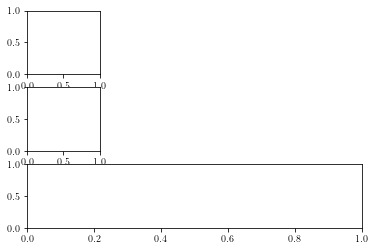

In [25]:
fig = plt.figure()
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
# spans two rows:
ax3 = fig.add_subplot(gs[2, :])

In [67]:
fig._supxlabel

In [65]:
dir(fig)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_label_groups',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_button_pick_id',
 '_cachedRenderer',
 '_callbacks',
 '_canvas_callbacks',
 '_clipon',
 '_clippath',
 '_constrained',
 '_constrained_layout_pads',
 '_contains',
 '_default_contains',
 '_dpi',
 '_gci',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_get_draw_artists',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_layoutgrid',
 '_localaxes',
 '_mouseover',
 '_normalize_grid_string',
 '_path_effects',
 '_picker',
 '_process_projection_requirements',
 '_rasterized',
 '_r

In [44]:
i

3

### Plot per dataset

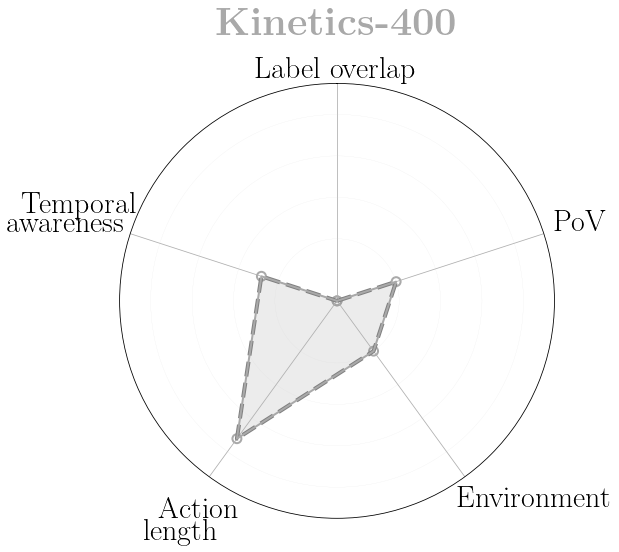

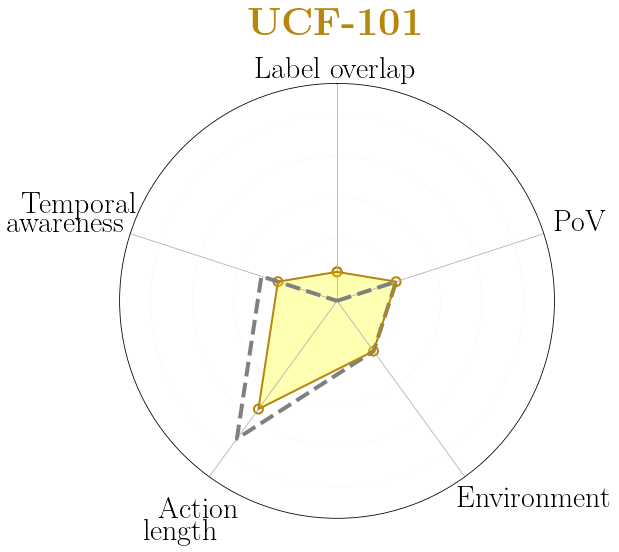

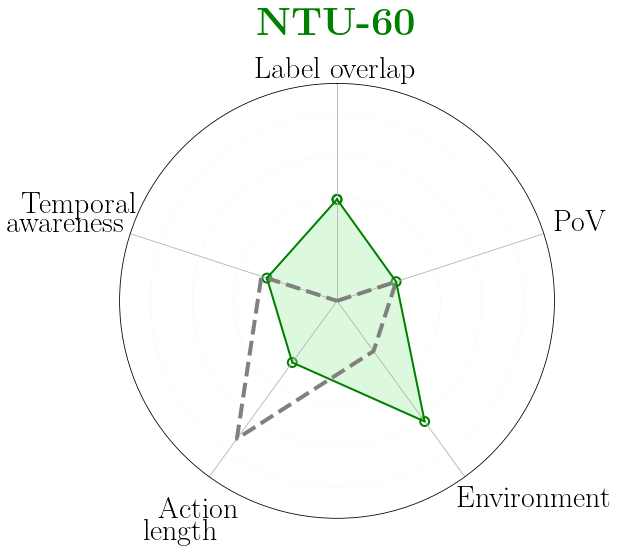

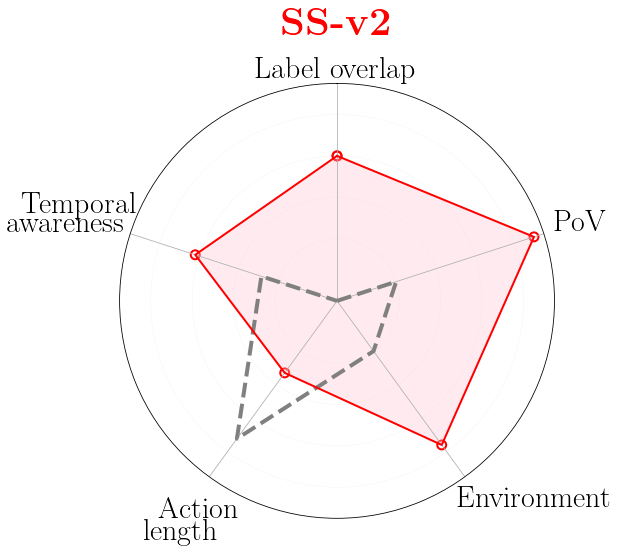

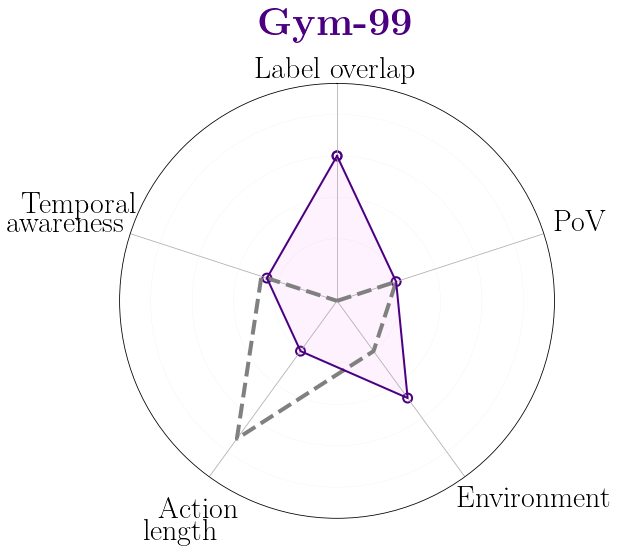

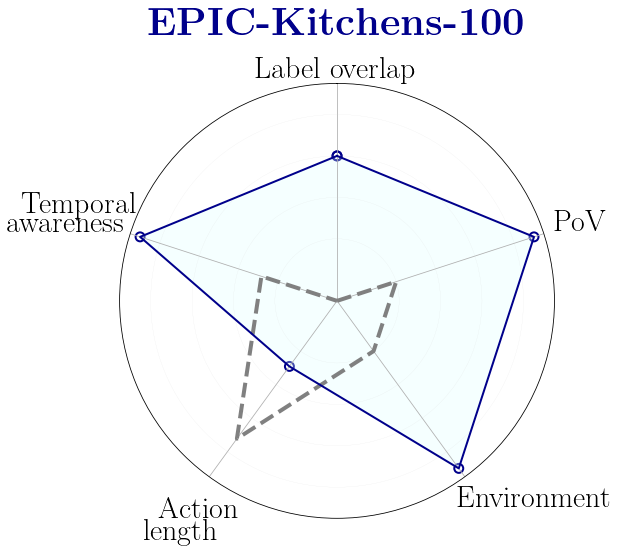

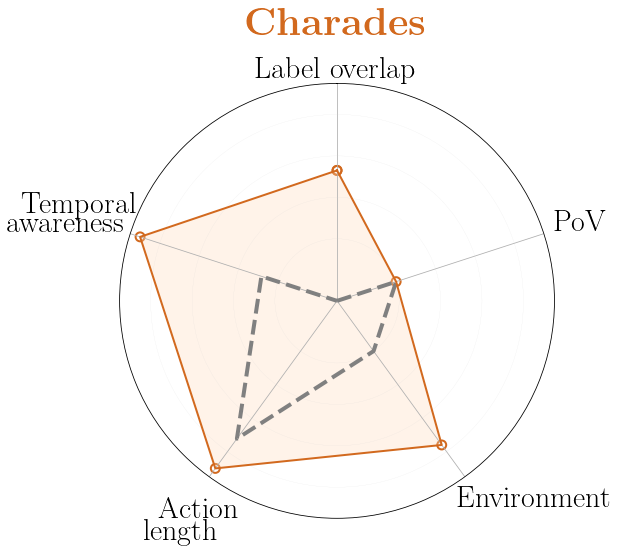

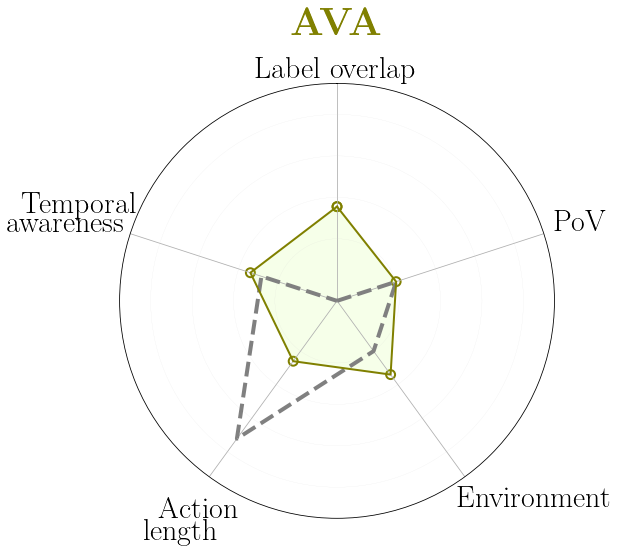

In [25]:
# define variables
# dataset = "UCF-101"
# dataset = "NTU-60"
# dataset = "SS-v2"
# dataset = "Gym-99"
# dataset = "EPIC-Kitchens-100"
# dataset = "Charades"
# dataset = "AVA"
# dataset = "Kinetics-400"

reference_dataset = "Kinetics-400"
reference_line_config = {
    "color": "gray",
    "linewidth": 4.,
}

# define constants
titlesize = 40
tickssize = 0.75 * titlesize

for dataset in colormap:


    # ------- PART 1: Create background

    # number of variable
    categories=list(df_scaled)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    f = plt.figure(figsize=(8,8))
    ax = f.add_subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_ylim(0.,1.05)

    # Draw one axe per variable + add labels
    bold_categories = [embolden(x) for x in categories]
    plt.xticks(angles[:-1], categories, fontsize=tickssize)

    # Draw ylabels
    plt.yticks([0.3,0.5,0.7,0.9], ["","","", ""], color="grey", size=7) 

    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values=df_scaled.loc[reference_dataset].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=reference_line_config["linewidth"], linestyle='dashed', label="Kinetics", color=reference_line_config["color"])
    ax.fill(angles, values, reference_line_config["color"], alpha=0.0)

    # Ind2
    facecolor, linecolor, facealpha = colormap[dataset]
    values=df_scaled.loc[dataset].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2.0, linestyle='solid', label="UCF-101", color=linecolor)
    ax.scatter(angles, values, linewidth=2.0, linestyle='solid', label="UCF-101", color=linecolor, facecolor="none", s=80)
    ax.fill(angles, values, facecolor, alpha=facealpha)

    # Add legend
    # plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # make gridlines light
    gridlines = ax.yaxis.get_gridlines()
    for i in range(len(ax.get_yticks())):
        gridlines[i].set_color("lightgray")
        gridlines[i].set_linewidth(0.1)

    thetas = ax.get_xticks()
    if titlesize < 25:
        rdeltas = [0.08, 0.05, 0.08, 0.23, 0.53]
    elif titlesize == 35:
        rdeltas = [0.1, 0.05, 0.1, 0.3, 0.75]
    elif titlesize == 40:
        rdeltas = [0.1, 0.05, 0.1, 0.35, 0.6]
    ax.text(-0.35, ax.get_ylim()[1] + rdeltas[0], s=categories[0], fontsize=tickssize)
    ax.text(thetas[1], ax.get_ylim()[1] + rdeltas[1], s=categories[1], fontsize=tickssize)
    ax.text(thetas[2] + 0.1, ax.get_ylim()[1] + rdeltas[2], s=categories[2], fontsize=tickssize)
    ax.text(thetas[3] + 0.1, ax.get_ylim()[1] + rdeltas[3], s=categories[3], fontsize=tickssize)
    ax.text(thetas[4] - 0.05, ax.get_ylim()[1] + rdeltas[4], s=categories[4], fontsize=tickssize)

    ax.set_xticklabels([])
    # Show the graph
    plt.title(embolden(dataset), y=1.1, fontsize=titlesize, color=linecolor)

    plt.savefig(f"../../results/plots/radar_{dataset}_v2.pdf", bbox_inches="tight")
    plt.show()

### Demo

In [51]:
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})

In [52]:
df

,group,var1,var2,var3,var4,var5
0,A,38.0,29,8,7,28
1,B,1.5,10,39,31,15
2,C,30.0,9,23,33,32
3,D,4.0,34,24,14,14


In [54]:
df

,group,var1,var2,var3,var4,var5
0,A,38.0,29,8,7,28
1,B,1.5,10,39,31,15
2,C,30.0,9,23,33,32
3,D,4.0,34,24,14,14


In [55]:
angles

[0.0,
 1.2566370614359172,
 2.5132741228718345,
 3.7699111843077517,
 5.026548245743669,
 0.0]

In [56]:
values

[1.5, 10, 39, 31, 15, 1.5]

In [59]:
values=df.loc[1].drop('group').values.flatten().tolist()


In [60]:
values

[1.5, 10, 39, 31, 15]

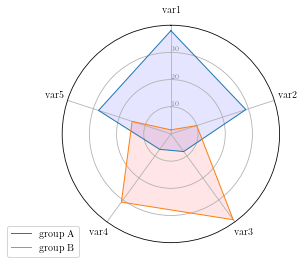

In [53]:
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()
